# Homework 2

## Markets

### UChicago Financial Mathematics

#### September 2024

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# Data

Use the data file `../data/treasury_quotes_<DATE>.xlsx`.
* replace `<DATE>` with `2024-05-31`
* consider this the date at the time of valuation.

In [6]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
date = '2024-05-31'
treasury_quotes = pd.read_excel(f'../data/treasury_quotes_{date}.xlsx', sheet_name='quotes').set_index('KYTREASNO')

***

# 1. Treasury Debt Composition

### Data
Use the data in the `quotes` tab.

## 1.1
Plot the total amount of outstanding debt maturing at each date

* Do this for `total size`, as that is listed for T-bills.
* (You could also examine `public size`, but that will exclude T-bills.)

Tip: `.pivot_table()` may be useful.

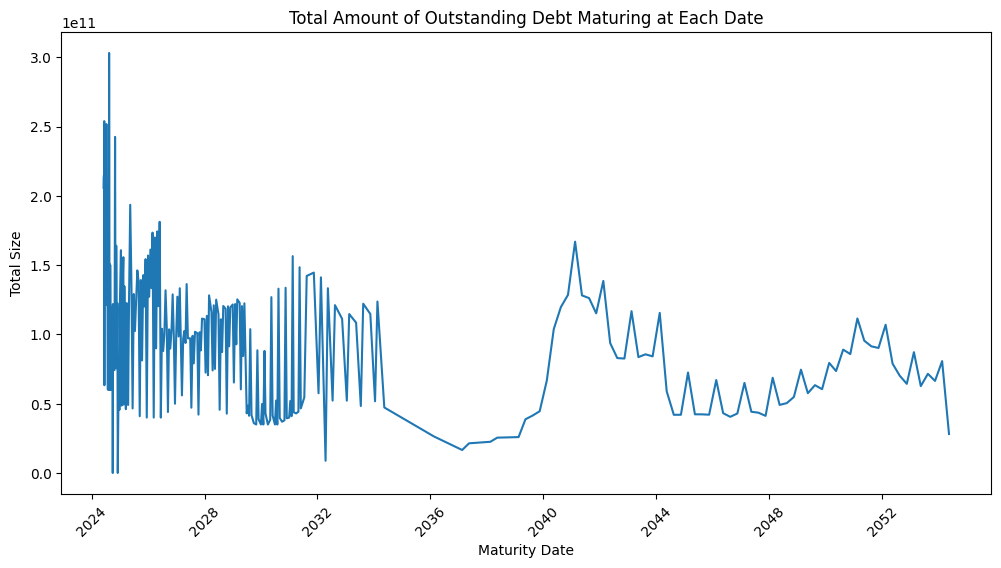

In [13]:
# Outstanding debt by maturity date
outstanding_debt = treasury_quotes.pivot_table(values='total size', index='maturity date', aggfunc='sum')

# Generate the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(outstanding_debt.index, outstanding_debt['total size'])
ax.set_xlabel('Maturity Date')
ax.set_ylabel('Total Size')
ax.set_title('Total Amount of Outstanding Debt Maturing at Each Date')
plt.xticks(rotation=45)
plt.show()


## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS.


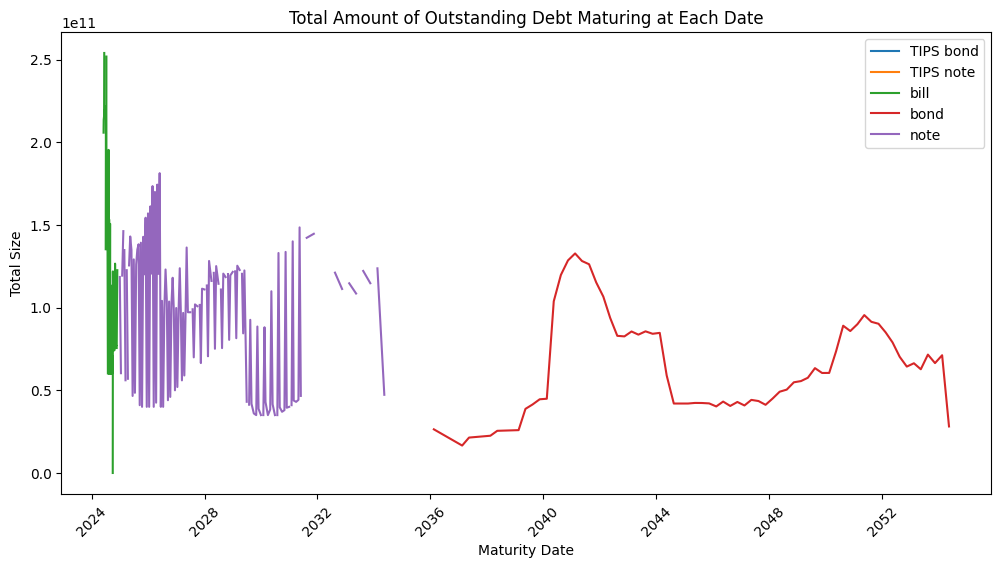

In [17]:
# Outstanding debt by maturity date
outstanding_debt_segmented = treasury_quotes.pivot_table(values='total size', index='maturity date', columns='type', aggfunc='sum')
outstanding_debt_segmented[]

# Generate the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(outstanding_debt_segmented.index, outstanding_debt_segmented['TIPS bond'], label='TIPS bond')
ax.plot(outstanding_debt_segmented.index, outstanding_debt_segmented['TIPS note'], label='TIPS note')
ax.plot(outstanding_debt_segmented.index, outstanding_debt_segmented['bill'], label='bill')
ax.plot(outstanding_debt_segmented.index, outstanding_debt_segmented['bond'], label='bond')
ax.plot(outstanding_debt_segmented.index, outstanding_debt_segmented['note'], label='note')
ax.set_xlabel('Maturity Date')
ax.set_ylabel('Total Size')
ax.set_title('Total Amount of Outstanding Debt Maturing at Each Date')
plt.xticks(rotation=45)
ax.legend()
plt.show()




## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

## 1.4
Make a pie chart of this total number (reported in 1.3.) 

## 1.5

Calculate the time-to-maturity (relative to the quoted date) for each issue.

Report the summary statistics of these time-to-maturities. 

Consider using `.describe()`

***

# 2 YTM and Price

The problems in this section ask you to calculate the **yield-to-maturity (YTM)** of various bonds.

You will need to use a nonlinear solver to solve for the YTM.

For any given bond, YTM ($y$) solves...

$$p = \sum_{i=1}^{2n}\frac{Fc/2}{(1+y/2)^i} + \frac{F}{(1+y/2)^{2n}}$$

where
* $p$ is the bond's price.
* $n$ is the number of years to maturity
* $c$ is the coupon rate (a percentage)
* $F$ is the face value. Use $F=100$

#### Solving for YTM
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. This function is imported with...

`from scipy.optimize import fsolve`

## 2.1

Consider a semiannual bond with the following stylized parameters:
* time-to-maturity of 30 years
* coupon rate: 3%
* Face value of 100

1. Assume the YTM is 5%. Calculate the price.
1. Assume the price is 87. Calculate the YTM.

## 2.2

### Data
Use the data in the `selected quotes` tab.
* It gives treasury bond data for various maturities, spaced roughly six months apart.
* Feel free to approximate the time-to-maturity to be exactly semiannually if that is easier for the problem below.
* Use the `price` column for the price data in the YTM formula. (No need to worry about "dirty" price, bid, ask, nor accrued interest.)

1. Calculate the yield-to-maturity for each issue. How close are your calculations to the provided column `ytm`?

1. Plot the time-to-maturity (TTM) against the calculated YTM.

***

# 3. Extra

If you would like to go further with computing yields, try these problems.

### Data
Use the data in the `selected quotes` tab.

Focus on the nominal securities. 
* Exclude any row with `type` of `TIPS note` or `TIPS bond`.

## 3.1
Plot the time-to-maturity against the provided YTM.

## 3.2

1. Calculate the YTM of each (nominal) bond issue in the data set. 

1. Report how far your YTM calculation is from those reported in the data set.

1. Report your calculated YTM for the issues where the dataset does not provide a YTM.


## 3.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `type`=`bill` or looking for `cpnrate` of 0.

***